In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from cv_proj_imports import *
from cv_proj_consts import *
from cv_proj_utils import *
from cv_proj_explore_map5_metric import *
from cv_proj_trainval_split import *
from cv_proj_arcface import *

/home/crazy_slime/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
# transformations
# we get the filenames as input, and output:
# x as the image
# y as the whale name
tfms_x = [PILImage.create]
tfms_y = [filename_label, lambda o: train_labels_dict[o], Categorize()]
tfms = [tfms_x, tfms_y]

ds_img_tfms = [ToTensor(), Resize(224)]

dl_tfms = [Cuda(), ByteToFloatTensor(), Normalize(*imagenet_stats)]
dl_tfms.extend(aug_transforms(
    do_flip=False, # flipping makes it a different whale identity!
    flip_vert=False,
    max_rotate=30.,
    max_zoom=1.,
    max_lighting=0.4,
    max_warp=0.1,
    p_affine=0.75,
    p_lighting=0.75,
    pad_mode=PadMode.Border
))

In [4]:
trainval_splits = get_trainval_splits()
train_ds = DataSource(train_image_files, tfms, splits=trainval_splits)
train_db = train_ds.databunch(after_item=ds_img_tfms, after_batch=dl_tfms, bs=32, num_workers=0)

We will use 1078 whales for initial train/val


In [5]:
from fastai2.vision.learner import _vgg_split

opt_func = partial(Adam, lr=5e-3, wd=0.01)

arcface_loss = ArcFaceLoss().cuda() # this may not be needed just try it out
custom_head=Customhead(1024,1078)

model = create_cnn_model(
    arch=models.vgg16_bn,
    nc = 2048,
    cut = -2,
    pretrained = True,
    custom_head=custom_head
)

learn = Learner(train_db, model, loss_func=arcface_loss, splitter = _vgg_split, opt_func=opt_func, metrics=[error_rate, mapk])

'Chosen LR: 0.000630957344480193'

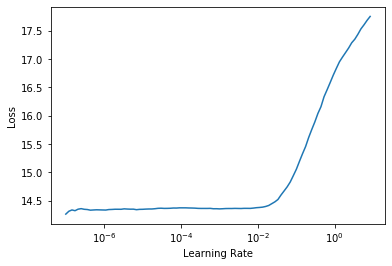

In [6]:
chosen_lr = find_best_lr(learn); f"Chosen LR: {chosen_lr}"

In [7]:
learn_cbs = [
    EarlyStoppingCallback(monitor='valid_loss', patience=20),
    SaveModelCallback(monitor='valid_loss', fname='embedding_vgg16_20191029_arcface_best'),
    ReduceLROnPlateau(monitor='valid_loss', patience=5)
]

learn.fit(500, lr=chosen_lr, cbs=learn_cbs)

Epoch 43: reducing lr to 6.309573444801929e-05
Epoch 80: reducing lr to 6.30957344480193e-06
Epoch 104: reducing lr to 6.30957344480193e-07
Epoch 109: reducing lr to 6.30957344480193e-08
Epoch 114: reducing lr to 6.30957344480193e-09
No improvement since epoch 99: early stopping


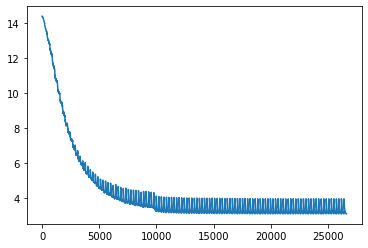

In [8]:
learn.recorder.plot_loss()

In [9]:
learn.unfreeze()

'Chosen LR: 0.0001'

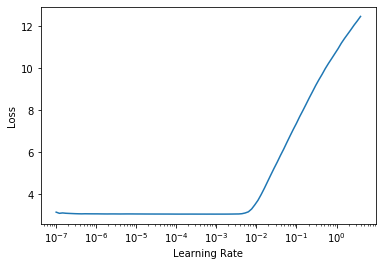

In [10]:
chosen_lr = find_best_lr(learn); f"Chosen LR: {chosen_lr}"

In [11]:
learn_cbs = [
    EarlyStoppingCallback(monitor='valid_loss', patience=20),
    SaveModelCallback(monitor='valid_loss', fname='embedding_vgg16_20191029_arcface_unfreeze_best'),
    ReduceLROnPlateau(monitor='valid_loss', patience=5)
]

learn.fit(500, lr=chosen_lr, cbs=learn_cbs)

Epoch 9: reducing lr to 1e-05
Epoch 21: reducing lr to 1.0000000000000002e-06
Epoch 36: reducing lr to 1.0000000000000002e-07
Epoch 41: reducing lr to 1.0000000000000002e-08
Epoch 46: reducing lr to 1.0000000000000003e-09
No improvement since epoch 31: early stopping


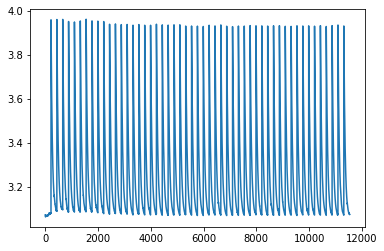

In [12]:
learn.recorder.plot_loss()

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat